# iPadとPythonを使って学ぶ, 初めてのBluetooth LE

---
 著者:  山本　昇, 
 所属:  J-PARCセンタ　加速器　制御　グループ, 
 公表日: 2020年　7月　5日
---

Bluetooth Low Energy(BLE)は Bluetooth 4規格(2009年) から導入された、低電力で動作するBluetoothデバイスという位置付けの規格です。

Bluetoothと同じ周波数帯(2.4GHz)を使いますが、OSから使う場合にはこれまでのBluetoothデバイスとは別の取り扱いが必要です。BLEはIoTのためのデバイスや、AppleのiBeaconなどで広く使われており、今後も利用が広がっていくと予想されます。

PythonにはBLEとの通信をサポートするモジュール `bleak` があります。`bleak` はLinux, windows, および macos での動作がサポートされています。
これらのプラットフォームではBLEと通信を実現すために異なったライブラリ(バックエンド）を利用しています。Linuxでは `bluez`, windowsは winrt, macosでは`Core Bluetooth Framework` がバックエンドライブラリとなっています。これらバックエンドの違いのために、一部の機能は特定のプラットフォームでは利用できない場合もありますので、注意しましょう。

[Bluetooth Low Energy の基礎 by Developpers blog]: https://blog.fenrir-inc.com/jp/2013/09/bluetooth-le-firststep.html
[bleak docuemnts]: https://bleak.readthedocs.io/en/latest/https://bleak.readthedocs.io/en/latest/

## 準備作業

プログラムを使いながら、BLEデバイスの使い方の説明を進めて行きます。
まずは、pythonプログラムでBLEデバイスにアクセスするために、[bleakモジュール][bleak in Github] を導入(インストール）します。

これは一度やっておけばOKです. `pip`はpython言語の一部ではありませんが、Jupyter/IPythonのnotebookでは、コードセルに埋め込まれた `pip`コマンドを、特別扱いで、kernelで実行してくれる様です。

bleakはまだ開発中のモジュールです。バージョンによって大きく動作が変わる可能性があります。バージョン番号を確認しておきましょう。

[bleak in Github]: https://github.com/hbldh/bleak

次のコードセルを実行して、pipでblakをインストールします。  pipのコードセルにはpipコマンドだけを入れておきます。
Jupyter/Jupyterlab以外の環境では、コマンドラインで、
``` bash
python3 -m pip install -U bleak
```
を実行します。

In [1]:
#pip install -U bleak

bleakはまだ開発中のモジュールです。バージョンによって大きく動作が変わる可能性があります。バージョン番号を確認しておきましょう。

In [2]:
import bleak
print(bleak.__version__)

0.14.3


# BLEでの通信
BLEを使って二つの装置が通信を始めるには、一般的には三つのステップを踏みます。

1. 探索(scan) : 必要な情報を持っているデバイスが付近にあるかどうかを探索する。
    * BLEでは、探索プロトコルを利用することで、付近にある利用可能なBLEから、デバイスの名前やアドレスなどその後の通信に必要な情報を入手することができます。
     
1. 接続(connect)： 探索ステップで見つかった必要な情報を持っているデバイスとの接続を確立する。
    * 探索で入手したアドレスを使って、目的とするデバイスとの接続を確立します。
     
     
1. 通信(read/write/notify) :接続されたチャンネルを使って双方向の通信を行う。要求に応じてデータの読み書きを行う `read/write`の他にデバイス側からデータを送信するnotifyと呼ばれる方法があります。
    
    1. read/write
    
    1. notify

探索時には、デバイスが提供する機能(サービス）を調べることで、接続が可能なデバイスを選択することが必要です。

## BLEデバイスを探してみる。 (デバイスの探索：Scan)

実際に BLE がどれ位我々の周りに存在しているかを、bleak/pythonを使って確認してみましょう。

次の`python`プログラムは、付近にある検出可能なBLEデバイスのリストを印刷してくれます。

`await`や`async`, `asyncio` といったキーワードがこのプログラムに登場しています。
`asyncio`は非同期処理向けに導入された標準モジュールの一つで、
`async`は定義される関数が、非同期関数であることを示しています。`awit`では非同期関数の処理の終了を待ちます。

これらの非同期処理の詳細についてはまた後ほど(あるいは別の文書で)説明しましょう。

この例では `bleak`モジュールの`BleakScanner`クラスを使い、検出されたBLEデバイスの情報、UUIDおよびその名前を取り出し印刷しています。

In [3]:
"""
from "bleak Documentation",by Henrik Blidh.
"""
import asyncio
import logging
from bleak import BleakScanner

async def main(timeout=5.0):
    devices=dict()
    eol=""
    for d in await BleakScanner.discover(timeout=timeout, service_uuids=[]):
        if d.name and (d.name != 'Unknown'):
            # device has attributes :'address',  'metadata',  'name',  'rssi' ,  'details'
            print(f"Found {eol}{d.name=},\n\t{d.address=},\n\t{d.rssi=},\n\t{d.metadata=},\n\t{d.details=}")
            devices[d.address]  =  d
            eol="\n"
    return devices

#asyncio.run(main())
ble_devices=await main(10) #jupyterでは既にloopが走っているので、awaitできる。というか、asyncio.runは使えない。
print("Found devices:", ble_devices)

Found d.name='Rbt-Sensor',
	d.address='71B7B76F-3B02-3694-977B-0E085407589E',
	d.rssi=-77,
	d.metadata={'uuids': [], 'manufacturer_data': {725: b'\x01\x82\xe6\nc\x16\x19\x01rZ\x0f\x00\xf1\x1bL\x00\x86\x03\xff'}, 'service_data': {}, 'delegate': <CentralManagerDelegate: 0x12df8ace0>},
	d.details=<CBPeripheral: 0x6000010ac140, identifier = 71B7B76F-3B02-3694-977B-0E085407589E, name = Rbt-Sensor, mtu = 0, state = disconnected>
Found 
d.name='NoboruのiPad',
	d.address='3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD',
	d.rssi=-35,
	d.metadata={'uuids': [], 'manufacturer_data': {76: b'\x10\x05\x03\x18S\x1ey'}, 'service_data': {}, 'delegate': <CentralManagerDelegate: 0x12df8ace0>},
	d.details=<CBPeripheral: 0x6000010a8960, identifier = 3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD, name = NoboruのiPad, mtu = 0, state = disconnected>
Found devices: {'71B7B76F-3B02-3694-977B-0E085407589E': 71B7B76F-3B02-3694-977B-0E085407589E: Rbt-Sensor, '3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD': 3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD: 

In [4]:
list(ble_devices.values())[0].rssi

-77

### CBPeripheralの情報　(macOS限定の話）

deviceオブジェクトの`.details`プロパティはpyobjcのオブジェクトとなっています。pyobjcオブジェクトは、各種のselectorメソッドを呼び出すことで情報を入手できます。

In [5]:
d=list(ble_devices.values())[0].details
print(d.name(), d.identifier(),  d.appearance(), d.attributeKeys())
print(d.BDAddress(), d.RSSI(), d.UUID(), d.state(), d.mtuLength(), d.appearance())
print(d.UUID().description())
print(d.UUID().zone(), d.UUID().debugDescription())

Rbt-Sensor 71B7B76F-3B02-3694-977B-0E085407589E 0 None
None None <CFUUID 0x6000021941e0> 71B7B76F-3B02-3694-977B-0E085407589E 0 0 0
<CFUUID 0x6000021941e0> 71B7B76F-3B02-3694-977B-0E085407589E
<objc.NSZonePtr object at 0x10720e910> <CFUUID 0x6000021941e0> 71B7B76F-3B02-3694-977B-0E085407589E


### 探索(scan): `bleak.BleakScanner`オブジェクト を使い、付近のデバイスを探索する。
先の例では、BealkScannerクラスのクラスメソッド`.discover`を使いました。

今度は、`bleak.BleakScannern`クラスのインスタンス(オブジェクト）を作成して利用可能なBLEデバイスを検索してみましょう。
ある短い検索時間内に検出されたデバイスの情報を印刷してみます。
装置の検出時に受信したアドバタイズメント(広告）データから、
デバイスの固有な識別番号(UUID:Universally Unique Identifier)と電波強度を知ることができます。

UUIDは128ビットの**一意**に定められた整数です。BLEではそれぞれのデバイスをこのUUIDを使って指定します。　
BLEデバイスはネットワーク装置として固有のMACアドレスも持っていますので、BLEデバイスをMACアドレスで指定する場合もあります。
(bleakでmacos向けのバックエンドcoreblutoothを使う場合には、デバイス指定にUUIDを使うことになっています。Linux/Windows では機器指定にBLEインタフェースのMACアドレスを使うこともできます。）

In [6]:
import asyncio
from bleak import BleakScanner

async def main(timeout=5.0):
    devices=set()
    async with BleakScanner(service_uuids=[]) as scanner:
        await asyncio.sleep(timeout) # 時間を区切ってscan 
        for d in await scanner.get_discovered_devices(): # このメソッドは廃止予定です。 .discovered_devices property　を使いましょう。
            if (d.address in devices) or (d.name == "Unknown"):
                continue
            print(f"{d.name=},\n\t{d.address=},\n\t{d.rssi=},\n\t{d.details=},\n\t{d.metadata=}")
            devices.add(d.address)
#asyncio.run(main())
await main(30.0)

d.name='Rbt-Sensor',
	d.address='71B7B76F-3B02-3694-977B-0E085407589E',
	d.rssi=-80,
	d.details=<CBPeripheral: 0x6000010acb40, identifier = 71B7B76F-3B02-3694-977B-0E085407589E, name = Rbt-Sensor, mtu = 0, state = disconnected>,
	d.metadata={'uuids': [], 'manufacturer_data': {725: b'\x01\xa1\xec\n\x94\x16\x1b\x01xZ\x0f\x00\x88\x19C\x00L\x03\xff'}, 'service_data': {}, 'delegate': <CentralManagerDelegate: 0x12e805380>}
d.name='NoboruのiPad',
	d.address='3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD',
	d.rssi=-35,
	d.details=<CBPeripheral: 0x6000010a5900, identifier = 3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD, name = NoboruのiPad, mtu = 0, state = disconnected>,
	d.metadata={'uuids': [], 'manufacturer_data': {76: b'\x10\x05\x03\x18S\x1ey'}, 'service_data': {}, 'delegate': <CentralManagerDelegate: 0x12e805380>}


/var/folders/3h/lqzhtkt17vv47gbtv470wcp40000gn/T/ipykernel_8045/447738524.py:8: FutureWarning: This method will be removed in a future version of Bleak. Use the `discovered_devices` property instead.
  for d in await scanner.get_discovered_devices(): # このメソッドは廃止予定です。 .discovered_devices property　を使いましょう。


#### `.discovered_devices`プロパティ
前節で使った`.get_discovered_devices()`メソッドはbleakバージョン0.11 で obsolete（将来のバージョンで取り除かれる）となっています。`.discovered_devices`プロパティを使うことが推奨されています。

`.discovered_devices` プロパティを使った場合のプログラムはこちらです。

In [7]:
import asyncio
from bleak import BleakScanner, __version__ as bleak_version
import logging

if bleak_version < "0.11":
    logging.warning("you must update bleak moulde newer than 0.11")

def show_device_info(device):
    if device.name == "Unknown":
      return
    print( 
            "Device name:", device.name if device.name else "Unknown",
            "\n\t address:", device.address,  
            ",\n\t RSSI:", device.rssi, 
            ",\n\t manufacturere_data:", device.metadata["manufacturer_data"],
                    ",\n\t uuids:", device.metadata["uuids"],
    )

async def main(timeout=5.0,service_uuids=[]):
    async with BleakScanner(service_uuids=service_uuids) as scanner:
        await asyncio.sleep(timeout) # 時間を区切ってscan        
        for d in scanner.discovered_devices:  # 将来に向けて、こちらを使うことが推奨されている。
            show_device_info(d)

#asyncio.run(main())
tsk=asyncio.ensure_future(main(3.0,))
if not tsk.get_loop().is_running():
    tsk.get_loop().run_until_complete(tsk)
else:
    await tsk

Device name: Rbt-Sensor 
	 address: 71B7B76F-3B02-3694-977B-0E085407589E ,
	 RSSI: -83 ,
	 manufacturere_data: {725: b'\x01\xa5\xe5\n\x9d\x16\x1b\x01~Z\x0f\x00\xe0\x1aB\x00B\x03\xff'} ,
	 uuids: []


#### 検出コールバックを使った処理
デバイスを探索している間に、デバイスからの応答を受け取る度に、callback関数を呼び出すように、プログラムを書き換えてみます。
`BleakScanner`のオブジェクトを作るさいに、`detection_callback`引数にコールバック関数を指定します。。

コールバック関数には、デバイスオブジェクトとアドバタイズメント(Advetisement)と呼ばれるデータが実引数として、渡されます。
Aアドバタイズメント データの中身をみてみましょう。アドバタイズメント データ中には、デバイスを同定するためのアドレス、受信した電波強度を表すRSSI(Received Signal Strength Indication、デバイス特有のデータであるmanufacturer_dataなどが納められていることがわかります。
`rssi`とデバイスの持っているデータを使って、スキャンしている装置(セントラル）の位置などの情報を推定し、利用するアプリケーション／サービスも使われています( Appel iBeaconなど)。

In [8]:
import asyncio
from bleak import BleakScanner
import time,datetime

# callback関数を定義します。
devices=set() # remember a address of detected device, to avoid to repeate outputs.

async def detection_callback(device, advertisement_data):
    if (device.address in devices) or (not device.name) or (device.name == "Unknown"):
        return
    devices.add(device.address)
    print("Device Detected", time.ctime(),)
    show_device_info(device)
    print( 
           "\t advertisement_data local_name:", advertisement_data.local_name or "Unknown",
            "\n\t manufacturer_data:", advertisement_data.manufacturer_data.items(),
            "\n\t platform_data:", advertisement_data.platform_data, 
            "\n\t service_data:", advertisement_data.service_data,
            "\n\t service_uuids:", advertisement_data.service_uuids,
            "\n\t time_stamp:", advertisement_data.platform_data[1].get("kCBAdvDataTimestamp"),
            end="\n\n"  
    )

#scannerを作成して、デバイスが発見されたら、上記のcallback関数を呼び出します。
async def main(timeout=5.0):
    async with BleakScanner(timeout=timeout, 
                            detection_callback=detection_callback,
                            service_uuids=[]) as scanner:
        await asyncio.sleep(timeout) # 時間を区切ってscan 

#asyncio.run(main())
await main(3.0)

Device Detected Tue Jul  5 15:36:45 2022
Device name: Rbt-Sensor 
	 address: 71B7B76F-3B02-3694-977B-0E085407589E ,
	 RSSI: -69 ,
	 manufacturere_data: {725: b'\x01\xa6\xe5\n\x9b\x16\x19\x01~Z\x0f\x00\x8d\x1bB\x00B\x03\xff'} ,
	 uuids: []
	 advertisement_data local_name: Rbt-Sensor 
	 manufacturer_data: dict_items([(725, b'\x01\xa6\xe5\n\x9b\x16\x19\x01~Z\x0f\x00\x8d\x1bB\x00B\x03\xff')]) 
	 platform_data: (<CBPeripheral: 0x600001094aa0, identifier = 71B7B76F-3B02-3694-977B-0E085407589E, name = Rbt-Sensor, mtu = 0, state = disconnected>, {
    kCBAdvDataIsConnectable = 1;
    kCBAdvDataLocalName = Rbt;
    kCBAdvDataManufacturerData = {length = 21, bytes = 0xd50201a6e50a9b1619017e5a0f008d1b42004203ff};
    kCBAdvDataRxPrimaryPHY = 0;
    kCBAdvDataRxSecondaryPHY = 0;
    kCBAdvDataTimestamp = "678695805.303322";
}, -69) 
	 service_data: {} 
	 service_uuids: [] 
	 time_stamp: 678695805.303322

Device Detected Tue Jul  5 15:36:45 2022
Device name: NoboruのiPad 
	 address: 3BEA82DA-74EB-F7

あなたの環境では何台のBLEデバイスが発見されるでしょうか？　試してみましょう。

このように、BLEは我々の日常環境に既に数多く存在しています(意識するにせよ、しないにせよ）。

#### 検出時コールバックの登録 `.register_detection_callback`

先ほどの例では、検出時コールバックはスキャナの生成時に指定しました。
検出時コールバックはスキャナの生成後に指定することも可能です。
検出時コールバックをスキャナが作成された後に登録するには、`.register_detection_callback`メソッドを使います。

In [9]:
# detection_callback を使う方法
import asyncio, time
from bleak import BleakScanner

async def main(wait=5.0):
    devices=set()
    async def detection_callback(device, advertisement_data): 
        if (device.address in devices)or (not device.name) or (device.name == "Unknown"):
            return
        print(time.ctime(), "device detected",)
        show_device_info(device)
        print( 
            "\t advertisement_data local_name:", advertisement_data.local_name or "Unknown",
            "\n\t manufacturer_data:", advertisement_data.manufacturer_data.items(),
            "\n\t platform_data:", advertisement_data.platform_data, 
            "\n\t service_data:", advertisement_data.service_data,
            "\n\t service_uuids:", advertisement_data.service_uuids,
            "\n\t time_stamp:", advertisement_data.platform_data[1].get("kCBAdvDataTimestamp"),
            end="\n\n"  
        )
        devices.add(device.address)

    async with BleakScanner(
          service_uuids=[]
    ) as scanner:
        scanner.register_detection_callback(detection_callback) # detection callbackを定義
        await asyncio.sleep(wait) #デバイスの検索を待ちます。
#
#asyncio.run(main())
await main(10)

Tue Jul  5 15:36:48 2022 device detected
Device name: NoboruのiPad 
	 address: 3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD ,
	 RSSI: -78 ,
	 manufacturere_data: {76: b'\x10\x05\x03\x18S\x1ey'} ,
	 uuids: []
	 advertisement_data local_name: NoboruのiPad 
	 manufacturer_data: dict_items([(76, b'\x10\x05\x03\x18S\x1ey')]) 
	 platform_data: (<CBPeripheral: 0x6000010b3a20, identifier = 3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD, name = NoboruのiPad, mtu = 0, state = disconnected>, {
    kCBAdvDataIsConnectable = 1;
    kCBAdvDataManufacturerData = {length = 9, bytes = 0x4c0010050318531e79};
    kCBAdvDataRxPrimaryPHY = 0;
    kCBAdvDataRxSecondaryPHY = 0;
    kCBAdvDataTimestamp = "678695808.0695291";
    kCBAdvDataTxPowerLevel = 12;
}, -78) 
	 service_data: {} 
	 service_uuids: [] 
	 time_stamp: 678695808.069529

Tue Jul  5 15:36:49 2022 device detected
Device name: Rbt-Sensor 
	 address: 71B7B76F-3B02-3694-977B-0E085407589E ,
	 RSSI: -86 ,
	 manufacturere_data: {725: b'\x01\xaa\xe5\n\x95\x16\x1b\x01\x80Z

# BLEの通信

BLEでの通信を理解するために必要となるいくつかの用語を紹介します。

Bluetoothの規格では、Blutooth　classic および　BLEの双方を同じ概念を使いながら規定するために`
何層にも別れたプロトコルのが規程されています。 ｀GATT: Generic Attribute profile`, `ATT: Attribute protocol`, `GAP: Generic Access profile`, `L2CAP: Logical Link Control and Adaptation protocol` といったレイヤーが規程されています。 BLEを使うには、最上位のGATTについて理解しておけば、大きな問題はないでしょう。

BLEのデバイスとの通信を開始するためには、付近の目的とするデバイスが存在するかどうか、探索を行います。

探索の結果を元に、目的とするデバイス(ペリフェラル）の識別子(UUIDあるいはMACアドレス）が判明すれば、そのデバイスと接続(connect)することができます(`ATT プロトコル`）。

デバイスは様々なデータを提供できますが、欲しいデータを指定する方法が必要です。
BLEでは、一つのペリフェラルが提供する色々なデータがサービス(Service)という形で整理されています。
サービスの一つ一つは、データの種類やデータそのものを表すキャラクタリスティックの集合体として表現されています。(`GATT** プロファイル` ) 次の節で、このサービスとキャラクタリスティックについて説明します。

### BLE Service と Characteristic

`GATTプロファイル` に基づくBLEとの通信では、 Service と Characteristicと言う概念に慣れる必要があります。 BLEのデバイス(Peripheralと呼びます）は 複数のサービスを提供します。サービスが提供する複数のデータはキャラクタリスティック(Characteristic)と呼ばれます。サービス、キャラクタリスティックはいずれも記述(description)と呼ばれる補助的情報をもつことができます。

Characteristicは(EPICS の　channelの様に）通信でやり取りする一つのデータのチャンネルです。 Charcteristicは決まったデータ型をもち、そのデータの意味を説明するdescriptionをプログラムで調べることもできます。またCharcteristicは固有のUUID(Universally Unique ID)を持っており、プログラムでCharacteristicを指定する際に使用します。

BLEでは、デバイス、サービス、キャラクタリスティック　および　デスクリプションは固有の識別子を持っており、BLEのライブラリでこれらを指定する際に、このUUIDを使います。

次に示すのはモデルナンバを問い合わせるチャンネル（UUID　2a24)の値を取り出すプログラムです。
デバイスのUUIDとこの問い合わせのUUIDを使って、問い合わせを送信します。

UUIDは128bitsの整数として表現されますが、よく使われるキャラクタリスティックや記述子については、あらかじめ定義された16bitsあるいは32bitsのUUIDを
使うことが許されています。16/32bitsのUUIDは"xxxxxxxx-0000-1000-8000-00805F9B34FB"の形式の128bitsのUUIDの省略形として解釈されます。

16bits/32bitsのUUIDは[Bluetooth, SIG.](https://www.bluetooth.com/) によって標準化されています[ [16bits UUID numbers document] ]。

[16bits UUID numbers document]: https://btprodspecificationrefs.blob.core.windows.net/assigned-values/16-bit%20UUID%20Numbers%20Document.pdf

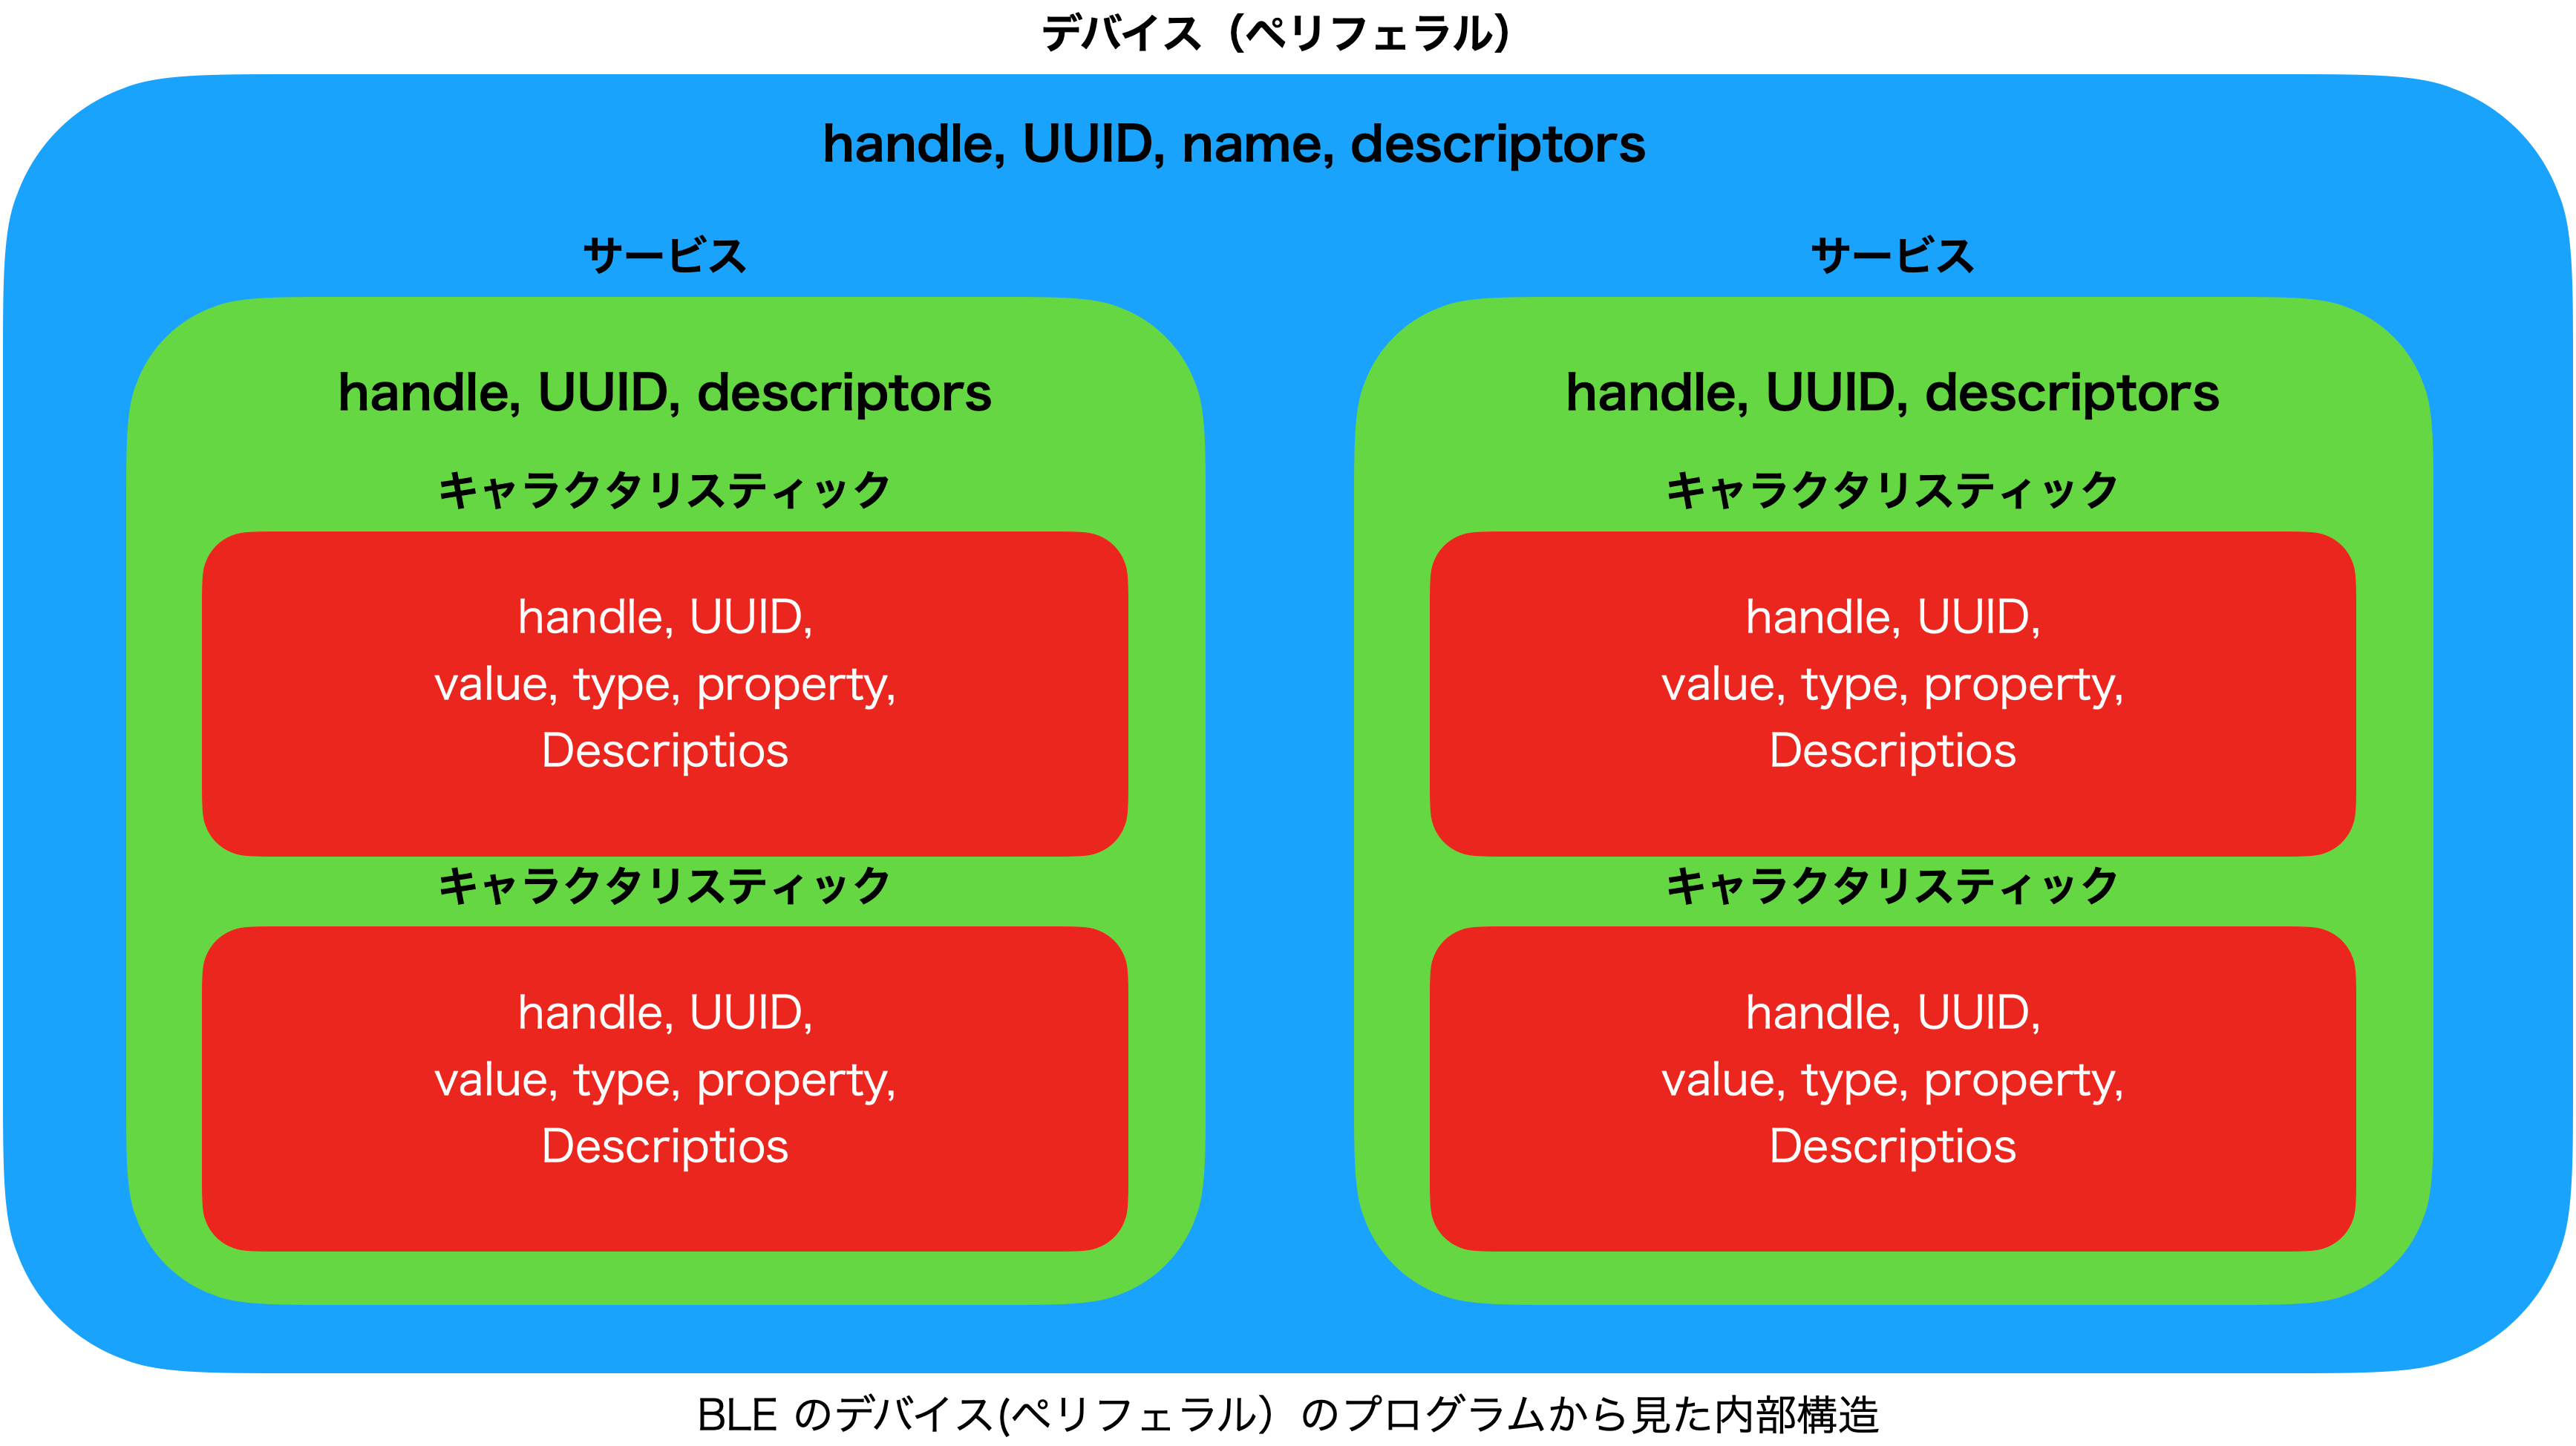

BLEでは特定のサービスやキャラクタリスティクを指定するために、UUIDを使います。UUIDは基本的に128ビットの固有な整数です。
よく使われるサービスやキャラクタリスティクについては、簡単化のために、16ビット（あるいは32ビット）のuuidが定義されています。
16(32)ビットのuuidは128bitのUUIDの"xxxxxxxx-0000-1000-8000-00805F9B34FB"に埋め込まれています。

In [10]:
import asyncio
from bleak import BleakClient

def UUID_from_uuid(uuid):
    """
    To reconstruct the full 128-bit UUID from the shortened version, 
    insert the 16- or 32-bit short value (indicated by xxxxxxxx, 
    including leading zeros) into the Bluetooth Base UUID:
    xxxxxxxx-0000-1000-8000-00805F9B34FB
    """
    return f"{uuid:08x}-0000-1000-8000-00805f9b34fb"

## キャラクタリスティックデータの読み取り

BLEの規格では、 `Model Number(MODEL_NBR)` および `製造者名称（MANU_NAME）` のキャラクタリスティクにはそれぞれ `0x2a25`, `0x2a29` の16bit UUIDが割り振られています。
このUUIDを使って、目的のデバイスのモデルナンバーおよび製造者名を取り出してみます。
デバイスの `read_gatt_char` メソッドに読み出したいキャラクタリスティクの `UUID` を渡しています。
戻り値は `bytearray` 型ですので、期待されるデータに合わせて、変換してやりましょう。
ここでは、`Model Number`および `製造者名称`がいずれも文字列型データですので、bytes型からdecodeメソッドをつかって変換しています。
この例では、`シリアルナンバー(2A25)`も読み出しを試みていますが、ipadはこのキャラクタリスティックを持たないので、エラー(`bleak.BleakError`)になってしまいます。

In [11]:
import asyncio,logging
import bleak
from bleak import BleakClient

macmini_uuid = "FB6FCEB4-ABA4-9499-7FB1-509DEE9607D7"
ipad_uuid = "3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD"

# 定義済み　16bits UUID の幾つか
SYSTEM_ID_UUID = UUID_from_uuid(0x2A23)  # System ID
MODEL_NBR_UUID = UUID_from_uuid(0x2A24)  # Model Number String "00002a24-0000-1000-8000-00805f9b34fb"　
SER_NBR_UUID   = UUID_from_uuid(0x2A25)  # Serial Number String
FIRMW_REV_UUID = UUID_from_uuid(0x2A26)  # Firmware Revision String
HW_REV_UUID    = UUID_from_uuid(0x2A27)  # Hardware Revision String
SW_REV_UUID    = UUID_from_uuid(0x2A28)  # Software Revision String
MANU_NAME_UUID = UUID_from_uuid(0x2A29)  # Manufacturer Name String
REG_CERT_UUID  = UUID_from_uuid(0x2A2A)  # IEEE 11073-20601 Regulatory Certification Data List
CUR_TM_UUID    = UUID_from_uuid(0x2A2B)  # Current Time

async def main(address):
    async with BleakClient(address) as client:
        if not client.is_connected:
            await client.connect()
        model_number = await client.read_gatt_char(MODEL_NBR_UUID) 
        print("Model Number: {0}".format(model_number.decode('ascii'))) # Model Numberは文字列型
        try:
            serial_number = await client.read_gatt_char(SER_NBR_UUID) 
            print("Serial Number: {0}".format(serial_number.decode('ascii'))) 
        except bleak.BleakError as m:
            logging.warning(m)
        manufacture = await client.read_gatt_char(MANU_NAME_UUID) 
        print("Manufacture: {0}".format(manufacture.decode('utf-8'))) #

#asyncio.run(main(address))
await main(ipad_uuid)

Model Number: iPad11,1
Manufacture: Apple Inc.


このように、`bleak.BleakClient`に接続デバイスのUUIDを引数として与えることで、BLEデバイスとの接続が確立されます。
`async with`構文をつかった場合には、コンテキストに入る際に`.connect`が呼び出され、出る際には `.disconenct`が
呼ばれます。`async with`構文を使わず、`bleak.BleakClient``bleak.BleakClient`によってペリフェラルオブジェクトを
作成した場合には、明示的に`.connect` および　`.disconnect` メソッドの呼び出しが必要ですので、ご注意ください。
ここでは、念の為、`.is_connected`で接続状況を調べて、コネクトされていなければ、`.connect`メソッドで再コネクトを試みています。

## デバイスが持つサービスとキャラクタリスティックの探索

次に、目的とするデバイスがどのようなサービスとキャラクタリスティクを持っているかを調べてみます。
BLEの規格に従うことで、デバイスが持つサービスとキャラクタリスティックの情報を入手できます。

接続されたデバイスのサービスのリストを\ `.services`\ プロパティで取得し、サービスの内容を\ `.description`\ でチェックします。

さらに、サービスの持つキャラクタリスティック(\ `.characteristics`\ )の要素毎に、\ `.description`\ と\ `.properties`\ の内容を調べます。

In [12]:
import asyncio
import bleak
from bleak import BleakClient
from UUID_from_uuid import UUID_from_uuid, dump_info

async def dump_info(client:BleakClient):
    print("\nデバイス Info:", client, (await client.read_gatt_char(MODEL_NBR_UUID)).decode("utf-8") )
    
    services=await client.get_services()

    for k in services.services:
        service=services.services[k]
        print(f"\nService[{service.handle}]: {service.description}", end="\n" )
        print(service.uuid)
        for char in service.characteristics:
            print(
                f"\nCharacteristic[{char.handle}]: '{char.description}' for \"{service.description}\""
            )
            print(f"char uuid: {char.uuid}")
            print(f"\t{char.properties =}")
            if "read" in char.properties:
                data = await client.read_gatt_char(char.uuid)
                print("\tdata type:", type(data))
                print("\tdata value:", data)
            for desc in char.descriptors:
                print("\t", f"desc[{desc.handle}]: {desc}")
                print("\t",
                    #desc.characteristic_handle,
                    #desc.characteristic_uuid,
                    f"obj: {desc.obj}, obj type:{type(desc.obj)}"
                )
    print()

この関数 `dump_info` を使って、目的とするデバイスのサービス内容を見てみましょう。
探索で見つかったデバイスのうち興味のあるデバイスのUUIDを特定して、そのデバイスのサービス内容を出力させてみましょう。
(ここに挙げたデバイスのUUIDは私の身の回りのデバイス探索で見つかったデバイス, Unknownを除く、の一部です。)

In [13]:
import asyncio
from bleak import BleakClient
from UUID_from_uuid import UUID_from_uuid, dump_info

ipad_uuid     = "3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD"
macmini_uuid  = "FB6FCEB4-ABA4-9499-7FB1-509DEE9607D7"
RBT_uuid      = "71B7B76F-3B02-3694-977B-0E085407589E"
NESCAFE_MAYA  = "01624841-DD84-2899-E8AB-329F736E4003"

async def main(address,timeout=10):
    # async with の　entry/exitでconnect/disconnectが実行される
    async with BleakClient(address,
                          ) as client:
        print("connected" if client.is_connected else "")
        await dump_info(client)

for uuid in (ipad_uuid, macmini_uuid, 
             RBT_uuid,  NESCAFE_MAYA
            ):
  try:
    await main(uuid,timeout=20)
  except bleak.BleakError as m:
    print(m)

connected

デバイス Info: BleakClientCoreBluetooth (3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD) iPad11,1

Service[10]: Apple Continuity Service
d0611e78-bbb4-4591-a5f8-487910ae4366

Characteristic[11]: 'Apple Continuity Characteristic' for "Apple Continuity Service"
	 char uuid: 8667556c-9a37-4c91-84ed-54ee27d90049
	 char.properties =['write', 'notify', 'extended-properties']
	 desc[13]: 00002900-0000-1000-8000-00805f9b34fb (Handle: 13): Characteristic Extended Properties
	
	 obj: <CBDescriptor: 0x600002fab090, UUID = Characteristic Extended Properties, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>
	 desc[14]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 14): Client Characteristic Configuration
	
	 obj: <CBDescriptor: 0x600002faab80, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Service[15]: Apple Nearby Service
9fa480e0-4967-4542-9390-d343dc5d04ae

Characteristic[16]: 'Nearby Characteristic' fo

このようにデバイスの詳細な情報をBLEのプロトコルを入手できるところは、BLEの興味深いところです。

iPadからの応答からは、独自のUUIDを持つサービス(Apple Continuity Service,Apple Nearby Service)と,
BLE規格の16bitsUUIDを持つサービス(Battery Service,Current Time Service,など）があることが読み取れます。

キャラクタリスティックのプロパティには、`read`,`write`, `notify`などが現れます。これは、このキャラクタリスティックに対して、これらの操作が可能であることをしめしています。`read`,`write`, `notify`は、EPICS CAの`get`, `put`, `monitor`に相当しています。プロパティにはこの他にも,
`Indicate`,`Authenticated Signed Writes`, `Extended Properties`などがありますが、これらのプロパティの使い方は規格書などを参考にしてください。

### デバイス指定方法をクロスプラットフォーム対応にする
ちょっと話がそれますが、bleakでデバイスを指定する方法は、元になっているプラットフォーム毎に異なっています。
macosではデバイスはUUIDで指定しますが、その他のプラットフォームでは　MACアドレスを使用します。
次のようなイディオムを使うことで、プラットフォームの依存性を隠すことができるでしょう。

In [14]:
import platform
# address 表記のばらつきを吸収 MAC address or UUID
device_address = (
    "24:71:89:cc:09:05"  # Linux or Windows
    if platform.system() != "Darwin" else 
    "243E23AE-4A99-406C-B317-18F1BD7B4CBE" # macOS
)

# `read`メソッドを使ってプロパティデータを読み出す。

iPadのもつサービス`Battery Service`および`Current Time Service`には、`read`プロパティをもつキャラクタリスティック
が存在します。

```
Characteristic[21]: 'Battery Level' for "Battery Service"
char uuid: 00002a19-0000-1000-8000-00805f9b34fb
char.properties =['read', 'notify']
```

```
Characteristic[25]: 'Current Time' for "Current Time Service"
char uuid: 00002a2b-0000-1000-8000-00805f9b34fb
char.properties =['read', 'notify']
```

`Current Time`プロパティのデータはつぎのプログラムのコメントにあるように、独自の形式を持っていますので、それぞれ適当な変換関数を用意しました。

In [15]:
import asyncio
import datetime,time,logging
from bleak import BleakClient

IPAD_UUID="3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD"

address=IPAD_UUID
#address=macmini_uuid

#Current Time Service
CTS_SERVICE_UUID = UUID_from_uuid(0x1805)
CTS_CHAR_UUID = UUID_from_uuid(0x2a2b)

CCC_UUID  = UUID_from_uuid(0x2902)
CTS_CHAR_handle=25

def show_CTS(cur):
    """
    https://stackoverflow.com/questions/58419880/convert-ble-current-time-to-date
    3.2.1.  Current Time        
    3.2.1.1.    UUID:       2A2B
    3.2.1.2.    Read:       Yes
    3.2.1.3.    Write:      Yes
    3.2.1.4.    Notify:     Yes
    3.2.1.5.    Value:      byte[10]    
    3.2.1.6.    Description: 0–1:  Year
                               2:  Month
                               3:  Day
                               4:  Hour
                               5:  Minute
                               6:  Seconds
                               7:  Day of Week
                               8:  256 Fractions of a Seconds
                               9:  Adjust Reason
    https://infocenter.nordicsemi.com/index.jsp?topic=%2Fcom.nordic.infocenter.sdk5.v15.3.0%2Fstructexact__time__256__t.html
    も参考に
    """
    DoW={0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed",4:"Thu", 5:"Fri", 6:"Sat",7:"Sun"}
    print(
        f"date:{cur[0]+(cur[1]<<8):04d}-{cur[2]:02d}-{cur[3]:02d}, {DoW[cur[7]]}",
        f"time: {cur[4]:02d}:{cur[5]:02d}:{cur[6] + cur[8]/256:02.3f}", 
        "Adjust Reason:",cur[9],
    )

def disconnected_callback(client):
    #logging.warning (f"disconeected {client}")
    logging.warning (f"disconeected")

#asyncio.run(main(address))
async with BleakClient(address) as client:
  
  if not client.is_connected:
    await client.connect()
    
  client.set_disconnected_callback(disconnected_callback)

  response_flag=True  # 
  chache_flag=False # ??
  delay=3.1
  loopCount=5

  print("start loop...",client.is_connected)
  for i in range(loopCount):
      output=await client.read_gatt_char(CTS_CHAR_UUID, 
                                       use_cached=chache_flag
                                      )
      show_CTS(output)
      await asyncio.sleep(delay)

  print("end loop...",client.is_connected)

  await asyncio.sleep(delay)
    
  print("finish:",await client.disconnect(), client.is_connected ) 

start loop... True
date:2022-07-05, Tue time: 15:37:38.152 Adjust Reason: 2
date:2022-07-05, Tue time: 15:37:41.285 Adjust Reason: 2
date:2022-07-05, Tue time: 15:37:44.434 Adjust Reason: 2
date:2022-07-05, Tue time: 15:37:47.570 Adjust Reason: 2
date:2022-07-05, Tue time: 15:37:50.719 Adjust Reason: 2
end loop... True


finish: True False


## notifyの利用例

`read`ではEPICS CAの`get`と同じように、`read`要求を出した時点でのデータが送り返されてきます。BLEにはEPICS の`monitor`機能に似て、
デバイス側で値が更新された時などに、デバイス側からクライアント側に通知を送ることができます。クライアント側では、コールバック関数を使って、送られたメッセージ(新しい値を含んでいる）を処理します。

いかに、`notify`の利用例を示します。ここではiPad（あるいはmacmini)の `Apple Continuity Service`を例にとって`notify`データを受け取る方法を示しまています。
デバイスの`.start_notify`メソッドをつかって、デバイスから`notify`メッセージが届いた時に呼ばれる`callback`関数を指定します(この例では`notification_handler`　). `Apple Continuity Service`が返す値の詳細が不明ですので、残念ながら意味のあるデータとして示すことはできません。このように、`notify`のコールバック関数には、そのメッセージを送ったキャラクタリスティックのハンドル番号(`sender`)と新しい値(`data`)が
渡されます。

iPadのCTS, BLサービスもnotify 機能を持つことになっていますが、 `Apple Continuity Service`と同じ方法ではnotifyメッセージを受信できませんでした。

In [16]:
import asyncio
import datetime,time,logging
import bleak
from bleak import BleakClient

# bleak moduleのlogging messageを表示させる。
logger=logging.getLogger('bleak.backends.corebluetooth.client')
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO) # this is a defalut value
#logger.setLevel(logging.DEBUG) # for debugging.

IPAD_UUID="3BEA82DA-74EB-F7EC-9D4F-4C6601269CAD"
macmini_uuid="FB6FCEB4-ABA4-9499-7FB1-509DEE9607D7"
address=macmini_uuid
address=IPAD_UUID

#Service[47]: Apple Continuity Service/Characteristic
ACS_UUID="d0611e78-bbb4-4591-a5f8-487910ae4366"
ACC_UUID="8667556c-9a37-4c91-84ed-54ee27d90049"

# Apple Nearby Searviceはnotifyの登録はできるが、応答がない。
ANC_UUID="af0badb1-5b99-43cd-917a-a77bc549e3cc"
BLC_UUID="00002a19-0000-1000-8000-00805f9b34fb"
CTSC_UUID="00002a2b-0000-1000-8000-00805f9b34fb"

async def notification_handler(sender, data):
    """Simple notification handler which prints the data received."""
    print(f"notify on {datetime.datetime.now().isoformat()}: {sender=}: [{len(data)}] {data=} ")

def disconnected_callback(client):
    #logging.warning (f"disconected {client}")
    logging.warning (f"disconected")

#asyncio.run(main(address))
async with BleakClient(address) as client:
  if not client.is_connected:
    print("connecting")
    await client.connect()
  print("connect:", client.is_connected)

  client.set_disconnected_callback(disconnected_callback)
  # check values of client characteristic configuration descriptors
  for cuuid in (ACC_UUID, ANC_UUID, BLC_UUID, CTSC_UUID):
    char=client.services.get_characteristic(cuuid )
    if not char: continue
    if 'read' in char.properties:
      try:
        output=await client.read_gatt_char(char, use_cached=False)
        print("current value for", char.description, output)
      except bleak.BleakError as m:
        print(m)
    for desc in char.descriptors:
      print(desc.description," has value ", 
            await client.read_gatt_descriptor(desc.handle, use_cached=False))
  # start notification
  for cuuid in (
      ACC_UUID, ANC_UUID, BLC_UUID, 
      CTSC_UUID,
    ):
    char=client.services.get_characteristic(cuuid )
    if not char: continue
    try:
      print("start nofity for", char.description,
            await client.start_notify(char, callback=notification_handler)
           )
    except bleak.BleakError as m:
          print(char.description, m)
    except ValueError as m:
          print(char.description, m)
    # recheck values of client characteristic configuration descriptors
    for desc in char.descriptors:
      print(desc.description," has value ",
            await client.read_gatt_descriptor(desc.handle, use_cached=False))

  response_flag=True  # 
  chache_flag=False # ??
  delay=10

  print(f"waiting({time.ctime()})...",client.is_connected)

  await asyncio.sleep(delay)

  print("disconnect:",await client.disconnect(), client.is_connected)
  await asyncio.sleep(3)
  print("restart:",await client.connect(), client.is_connected)
  for cuuid in (ACC_UUID, ANC_UUID,BLC_UUID,CTSC_UUID):
      char=client.services.get_characteristic(cuuid)
      if not char: continue
      # recheck values of client characteristic configuration descriptors
      for desc in char.descriptors:
        print(desc.description, " has value ",
            await client.read_gatt_descriptor(desc.handle, use_cached=False))

  await asyncio.sleep(delay)

  for cuuid in (ACC_UUID, ANC_UUID,BLC_UUID,CTSC_UUID):
      char=client.services.get_characteristic(cuuid)
      if not char: continue
      try:
        print(await client.stop_notify(char))
      except bleak.BleakError as m:
        print(char.description, m)
      except ValueError as m:
          print(m, " for ", char.description,)
        
      # recheck values of client characteristic configuration descriptors
      for desc in char.descriptors:
        print(desc.description, " has value ",
            await client.read_gatt_descriptor(desc.handle, use_cached=False))
       
  print("finish:",await client.disconnect(), client.is_connected)

connect: True
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')
current value for Battery Level bytearray(b'9')
Client Characteristic Configuration  has value  bytearray(b'')
current value for Current Time bytearray(b'\xe6\x07\x07\x05\x0f&\x02\x02\x04\x02')
Client Characteristic Configuration  has value  bytearray(b'')
start nofity for Apple Continuity Characteristic None
notify on 2022-07-05T15:38:02.203109: sender=11: [47] data=bytearray(b'-\x00 \x04\x00\x04\x00\x8e\x83-\xaa\x00\x00\x00\x00\xb0\x02\xff\xffu\xbd\x00\x00\x02\x04\x05(\x01\x03\x03\x05\x01\x01\x08\n\xde\xdb\x1e\xc3\x00\x00\x00\x00\x04\x02\x00\x00') 
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'\x00')
start nofity for Nearby Characteristic

disconnect: True False
restart: True True
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')
Client Characteristic Configuration  has value  bytearray(b'')
Client Characteristic Configuration  has value  bytearray(b'')
None
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')
None
Characteristic Extended Properties  has value  bytearray(b'\x00')
Client Characteristic Configuration  has value  bytearray(b'')


None
Client Characteristic Configuration  has value  bytearray(b'')
None
Client Characteristic Configuration  has value  bytearray(b'')
finish: True False


iPadのCTS, BLサービスで、notifyが動作しない原因はセキュリティのためで、追加のおまじないが必要かもしれない。
ということで、いろいろ調べてみたが、まだ解決していません。

[Developer Forums](https://developer.apple.com/forums/thread/8577)とか、[Blogの記事](https://blog.fenrir-inc.com/jp/2013/10/bluetooth-le-ios-1.html)とかを調べてみたんですが、。。。

start_notificationsの中で、`self.peripheral.setNotifyValue_forCharacteristic_(True, characteristic)` が呼ばれている。
start_notifyの中で、start_notificationsが呼ばれているということで、必要なことは実行されているように見えるのですが。
しかも、まれにプログラムを書き換えてテストをしているときに突如notifyメッセージが印刷されることがあります。

CTSにnotifyの間隔を通知する必要があるのかもしれません。

1. The new time information differs by more than 1 minute from the server device time
previous to the update.
2. The update was caused by the client device (interacting with another service).1. The new time information differs by more than 1 minute from the server device time
previous to the update.
2. The update was caused by the client device (interacting with another service).

とあるので、1分以上は待つ必要がありそうです。

# 付録：　`オムロン　2JCIE-BU01`
J-PARC加速器制御棟制御室では、某氏の`オムロン　2JCIE-BU01`が応答します。

### `RBT_uuid="71B7B76F-3B02-3694-977B-0E085407589E"`のDevice Information

```
デバイス Info: BleakClientCoreBluetooth (71B7B76F-3B02-3694-977B-0E085407589E) 2JCIE-BU01

Service[11]: Unknown
ab705000-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[12]: 'Unknown' for "Unknown"
	 char uuid: ab705004-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00')

Characteristic[14]: 'Unknown' for "Unknown"
	 char uuid: ab705005-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['write']

Characteristic[16]: 'Unknown' for "Unknown"
	 char uuid: ab705006-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')

Characteristic[18]: 'Unknown' for "Unknown"
	 char uuid: ab70500a-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['notify']
	 desc[20]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 20): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f7b030, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[21]: 'Unknown' for "Unknown"
	 char uuid: ab70500b-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['notify']
	 desc[23]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 23): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f4cb10, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[24]: 'Unknown' for "Unknown"
	 char uuid: ab70500c-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['notify']
	 desc[26]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 26): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f73120, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[27]: 'Unknown' for "Unknown"
	 char uuid: ab70500d-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['notify']
	 desc[29]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 29): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f489f0, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Service[30]: Unknown
ab705200-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[31]: 'Unknown' for "Unknown"
	 char uuid: ab705201-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00')

Characteristic[33]: 'Unknown' for "Unknown"
	 char uuid: ab705202-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00')

Characteristic[35]: 'Unknown' for "Unknown"
	 char uuid: ab705203-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x01\x00')

Service[37]: Unknown
ab705210-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[38]: 'Unknown' for "Unknown"
	 char uuid: ab705211-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\xac\r\xa0\x0f\xe8\x03\x00\x00d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[40]: 'Unknown' for "Unknown"
	 char uuid: ab705212-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\xac\r\xe8\x03d\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[42]: 'Unknown' for "Unknown"
	 char uuid: ab705213-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x004!\x1c%\xac\r\xe8\x03d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[44]: 'Unknown' for "Unknown"
	 char uuid: ab705214-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'4!\xac\rd\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[46]: 'Unknown' for "Unknown"
	 char uuid: ab705215-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00,\x01\xe8\x03d\x00\n\x00d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[48]: 'Unknown' for "Unknown"
	 char uuid: ab705216-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b',\x01d\x00d\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[50]: 'Unknown' for "Unknown"
	 char uuid: ab705217-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00<(\x04)\xe4%\x1c%d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[52]: 'Unknown' for "Unknown"
	 char uuid: ab705218-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'<(\xe4%d\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[54]: 'Unknown' for "Unknown"
	 char uuid: ab705219-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00X\x1b(#\x88\x13\xa0\x0f\xe8\x03\xd0\x07\xe8\x03\xd0\x07\xff\xff')

Characteristic[56]: 'Unknown' for "Unknown"
	 char uuid: ab70521a-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'X\x1b\x88\x13\xe8\x03\xe8\x03\xe8\x03\xe8\x03\xe8\x03\xe8\x03\x08\x08\x08\x08')

Characteristic[58]: 'Unknown' for "Unknown"
	 char uuid: ab70521b-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\xfa\x00\xc2\x01d\x002\x002\x00d\x002\x00d\x00\xff\xff')

Characteristic[60]: 'Unknown' for "Unknown"
	 char uuid: ab70521c-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\xfa\x00d\x002\x002\x002\x002\x002\x002\x00\x08\x08\x08\x08')

Characteristic[62]: 'Unknown' for "Unknown"
	 char uuid: ab70521d-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\xdc\x05\xc4\t\xe8\x03X\x02d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[64]: 'Unknown' for "Unknown"
	 char uuid: ab70521e-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\xdc\x05\xe8\x03d\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[66]: 'Unknown' for "Unknown"
	 char uuid: ab70521f-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00L\x1d@\x1fp\x17|\x15\xc8\x00\xf4\x01\xc8\x00\xf4\x01\xff\xff')

Characteristic[68]: 'Unknown' for "Unknown"
	 char uuid: ab705220-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'L\x1dp\x17\xc8\x00\xc8\x00\xc8\x00\xc8\x00\xc8\x00\xc8\x00\x08\x08\x08\x08')

Characteristic[70]: 'Unknown' for "Unknown"
	 char uuid: ab705221-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\xf0\n\x1c\x0c\xc4\t\x98\x08d\x00\xc8\x00d\x00\xc8\x00\xff\xff')

Characteristic[72]: 'Unknown' for "Unknown"
	 char uuid: ab705222-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\xf0\n\xc4\td\x00d\x00d\x00d\x00d\x00d\x00\x08\x08\x08\x08')

Characteristic[74]: 'Unknown' for "Unknown"
	 char uuid: ab705226-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00d\x00\xaa\x00\x1e\x002\x00')

Characteristic[76]: 'Unknown' for "Unknown"
	 char uuid: ab705227-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\xf4\x01\xe8\x03\xc8\x00\xf4\x01')

Characteristic[78]: 'Unknown' for "Unknown"
	 char uuid: ab705228-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\xac\r\x88\x13\xf4\x01\xe8\x03')

Service[80]: Unknown
ab705400-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[81]: 'Unknown' for "Unknown"
	 char uuid: ab705401-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\xff')

Characteristic[83]: 'Unknown' for "Unknown"
	 char uuid: ab705402-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x01')

Characteristic[85]: 'Unknown' for "Unknown"
	 char uuid: ab705403-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00')

Service[87]: Unknown
ab705010-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[88]: 'Unknown' for "Unknown"
	 char uuid: ab705012-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'notify']
	data type: <class 'bytearray'>
	data value: bytearray(b'(}\n\x15\x16\x15\x01e`\x0f\x00\x10\x19\x19\x009\x02')
	 desc[90]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 90): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f4a460, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[91]: 'Unknown' for "Unknown"
	 char uuid: ab705013-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'notify']
	data type: <class 'bytearray'>
	data value: bytearray(b'(K\x1dA\t\x00\x00\x00\x00\x00\x00\x00\xb6\x07\xa4\x16\\\xe2')
	 desc[93]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 93): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f73030, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[94]: 'Unknown' for "Unknown"
	 char uuid: ab705014-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'notify']
	data type: <class 'bytearray'>
	data value: bytearray(b'(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
	 desc[96]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 96): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f4a4c0, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[97]: 'Unknown' for "Unknown"
	 char uuid: ab705015-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'notify']
	data type: <class 'bytearray'>
	data value: bytearray(b'(\x00\x00\x00\x00\x00\x00\x00')
	 desc[99]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 99): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f72fa0, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Characteristic[100]: 'Unknown' for "Unknown"
	 char uuid: ab705016-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'notify']
	data type: <class 'bytearray'>
	data value: bytearray(b'(\x00\x00\x00\x00\x00\x00\x00\x02\xd6\x07w\x16g\xe2')
	 desc[102]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 102): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f4a370, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Service[103]: Unknown
ab705110-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[104]: 'Unknown' for "Unknown"
	 char uuid: ab705111-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x07\x00\x00\x00\x00')

Characteristic[106]: 'Unknown' for "Unknown"
	 char uuid: ab705112-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00')

Characteristic[108]: 'Unknown' for "Unknown"
	 char uuid: ab705113-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00')

Characteristic[110]: 'Unknown' for "Unknown"
	 char uuid: ab705114-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')

Characteristic[112]: 'Unknown' for "Unknown"
	 char uuid: ab705115-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\xa0\x00\x01')

Characteristic[114]: 'Unknown' for "Unknown"
	 char uuid: ab705116-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['write']

Characteristic[116]: 'Unknown' for "Unknown"
	 char uuid: ab705117-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00')

Characteristic[118]: 'Unknown' for "Unknown"
	 char uuid: ab705118-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['write']

Characteristic[120]: 'Unknown' for "Unknown"
	 char uuid: ab705119-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read', 'write']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00')

Service[122]: Unknown
ab705030-0a3a-11e8-ba89-0ed5f89f718b

Characteristic[123]: 'Unknown' for "Unknown"
	 char uuid: ab705031-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x1f\x00\x00\x00*\x00\x00\x00')

Characteristic[125]: 'Unknown' for "Unknown"
	 char uuid: ab705032-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['write']

Characteristic[127]: 'Unknown' for "Unknown"
	 char uuid: ab705033-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'\x00\x00\x00')

Characteristic[129]: 'Unknown' for "Unknown"
	 char uuid: ab705034-0a3a-11e8-ba89-0ed5f89f718b
	 char.properties =['notify']
	 desc[131]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 131): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f716e0, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Service[132]: Nordic Semiconductor ASA
0000fe59-0000-1000-8000-00805f9b34fb

Characteristic[133]: 'Buttonless DFU' for "Nordic Semiconductor ASA"
	 char uuid: 8ec90003-f315-4f60-9fb8-838830daea50
	 char.properties =['write', 'indicate']
	 desc[135]: 00002902-0000-1000-8000-00805f9b34fb (Handle: 135): Client Characteristic Configuration
	 uuid: 00002902-0000-1000-8000-00805f9b34fb description: Client Characteristic Configuration
	 obj: <CBDescriptor: 0x600003f725b0, UUID = Client Characteristic Configuration, value = (null)>, obj type:<objective-c class CBDescriptor at 0x1f543fc38>

Service[136]: Device Information
0000180a-0000-1000-8000-00805f9b34fb

Characteristic[137]: 'Manufacturer Name String' for "Device Information"
	 char uuid: 00002a29-0000-1000-8000-00805f9b34fb
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'OMRON')

Characteristic[139]: 'Model Number String' for "Device Information"
	 char uuid: 00002a24-0000-1000-8000-00805f9b34fb
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'2JCIE-BU01')

Characteristic[141]: 'Serial Number String' for "Device Information"
	 char uuid: 00002a25-0000-1000-8000-00805f9b34fb
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'31X8MY0152')

Characteristic[143]: 'Hardware Revision String' for "Device Information"
	 char uuid: 00002a27-0000-1000-8000-00805f9b34fb
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'01.00')

Characteristic[145]: 'Firmware Revision String' for "Device Information"
	 char uuid: 00002a26-0000-1000-8000-00805f9b34fb
	 char.properties =['read']
	data type: <class 'bytearray'>
	data value: bytearray(b'00.69')
    
```

ちなみに、`オムロン　2JCIE-BU01`では次のように、問題なくnotifyが動作します。

In [17]:
from bleak import BleakClient
import asyncio,datetime,logging

RBT_UUID="71B7B76F-3B02-3694-977B-0E085407589E"
char_uuid="ab705012-0a3a-11e8-ba89-0ed5f89f718b"
#char_uuid="00002a2b-0000-1000-8000-00805f9b34fb" #Current_time

def notification_handler(sender, data):
    """Simple notification handler which prints the data received."""
    print(f"notify on {datetime.datetime.now().isoformat()}: {sender=}: {data=} ")
    
def disconnected_callback(client):
    #logging.warning (f"disconeected {client}")
    logging.warning (f"disconeected")

async with BleakClient(RBT_UUID) as client:
  
  await asyncio.sleep(3)

  if not client.is_connected:
    print("connecting")
    await client.connect()
  
  print("connected?", client.is_connected)

  client.set_disconnected_callback(disconnected_callback)

  await client.start_notify(char_uuid, 
                          callback=notification_handler)
  await asyncio.sleep(5)

  try:
    await client.stop_notify(char_uuid)
  except:
    pass
  finally:
    await client.disconnect()
  print(client.is_connected)

connected? True
notify on 2022-07-05T15:38:33.895717: sender=88: data=bytearray(b'\x13\xd0\nf\x16\x1b\x01]Z\x0f\x00\x1c\x1bO\x00\x9d\x03') 
notify on 2022-07-05T15:38:34.885755: sender=88: data=bytearray(b'\x14\xce\nl\x16\x19\x01cZ\x0f\x00\xa0\x1cO\x00\x9d\x03') 
notify on 2022-07-05T15:38:35.874975: sender=88: data=bytearray(b'\x15\xca\nu\x16\x19\x01fZ\x0f\x00\t\x1cO\x00\x9d\x03') 
notify on 2022-07-05T15:38:36.895586: sender=88: data=bytearray(b'\x16\xc9\nw\x16\x1b\x01hZ\x0f\x00r\x1aO\x00\x9d\x03') 
notify on 2022-07-05T15:38:37.885348: sender=88: data=bytearray(b'\x17\xc6\n}\x16\x19\x01hZ\x0f\x00\xe9\x1aM\x00\x8d\x03') 


False


環境センサ　2JCIE-BU01ユーザーズマニュアル(OMRON  CDSC-016.pdf)によれば、UUID=0x5012 のデータの意味は

| Byte | Field | Format | Contents/Range | Unit|
| ---- | ----- | ------ | -------- | --- |
| 0 | Seuqence Number| Unit8 | 0x00 - 0xFF | |
|1-2| Temperature| SInt16| -40.00 to 125.00 | 0.01degC|
|3-4| Relative Humidity| Sint16|0.00 to 100.0| 0.01 %RH |
|5-6| Ambient light | Sint16 | 0.to 30000| 1 lx|
|7-10| Barometric Pressure|Sint32|300.0 to 1100.0| 0.001 hPa|
|11-12| Sound Noise | Sint16| 33.00 to 120.0 | 0.01dB
|13-14| eTVOC | Sing16 | 0 to 29206 | 1ppb |
|15-16| eCO2| Sint16| 400 to 32767 | 1 ppb|

となっています。このデータの解釈用のルーチンを作ってみましょう。

In [18]:
bs=(
b"\xf3\xe5\n\x92\x15\'\x01\x17d\x0f\x00_\x16\xce\x00\x0c\x06",
b"\xf4\xe4\n\x94\x15\'\x01\x15d\x0f\x00\xbb\x14\xce\x00\x0c\x06",
b"\xf5\xe0\n\x9d\x15\'\x01\x12d\x0f\x00\xca\x15\xce\x00\x0c\x06", 
b"\xf6\xe0\n\x9c\x15\'\x01\x16d\x0f\x00\x8d\x16\xce\x00\x0c\x06", 
b"\xf7\xe1\n\x9c\x15\'\x01\x1bd\x0f\x00\xb3\x15\xc6\x00\x03\x06",)

def BAtoVALS(b):
  endian="little"
  sn=b[0]
  T=0.01*int.from_bytes(b[1:3],endian)
  RH  =0.01*int.from_bytes(b[3:5],endian)
  AL  =     int.from_bytes(b[5:7],endian)
  BP  =0.001*int.from_bytes(b[7:11],endian)
  SN  =0.01*int.from_bytes(b[11:13],endian)
  eTVOC  = int.from_bytes(b[13:15],endian)
  eCO2  = int.from_bytes(b[15:17],endian)
  
  return(sn, T, RH, AL, BP, SN, eTVOC, eCO2)

print(("sn", "T", "RH", "AL", "BP", "SN", "eTVOC", "eCO2"))
for b in bs:
  print(BAtoVALS(b))

('sn', 'T', 'RH', 'AL', 'BP', 'SN', 'eTVOC', 'eCO2')
(243, 27.89, 55.22, 295, 1008.663, 57.27, 206, 1548)
(244, 27.88, 55.24, 295, 1008.6610000000001, 53.07, 206, 1548)
(245, 27.84, 55.33, 295, 1008.658, 55.78, 206, 1548)
(246, 27.84, 55.32, 295, 1008.662, 57.730000000000004, 206, 1548)
(247, 27.85, 55.32, 295, 1008.667, 55.550000000000004, 198, 1539)


In [19]:
from bleak import BleakClient
import asyncio,datetime,logging

RBT_UUID="71B7B76F-3B02-3694-977B-0E085407589E"
char_uuid="ab705012-0a3a-11e8-ba89-0ed5f89f718b"

def notification_handler(sender, data):
    """Simple notification handler which prints the data received."""
    endian="little"
    sn=data[0]
    T=0.01*int.from_bytes(data[1:3],endian)
    RH  =0.01*int.from_bytes(data[3:5],endian)
    AL  =     int.from_bytes(data[5:7],endian)
    BP  =0.001*int.from_bytes(data[7:11],endian)
    SN  =0.01*int.from_bytes(data[11:13],endian)
    eTVOC = int.from_bytes(data[13:15],endian)
    eCO2  = int.from_bytes(data[15:17],endian)
    print(f"notify on {datetime.datetime.now().isoformat()}; {sender=};",
          f"{sn=}, {T=:.2f}, {RH=:.2f}, {AL=}, {BP=:.2f}, {SN=:.2f}, {eTVOC=}, {eCO2=}")

def disconnected_callback(client):
    logging.warning (f"disconeected")

async with BleakClient(RBT_UUID) as client:
  
  await asyncio.sleep(3)

  if not client.is_connected:
    await client.connect()
  
  print("connected?", client.is_connected)

  client.set_disconnected_callback(disconnected_callback)

  await client.start_notify(char_uuid, 
                          callback=notification_handler)
  await asyncio.sleep(5)

  try:
    await client.stop_notify(char_uuid)
  except:
    pass
  finally:
    await client.disconnect()
  print(client.is_connected)

connected? True
notify on 2022-07-05T15:38:42.881358; sender=88; sn=28, T=27.60, RH=57.53, AL=281, BP=1006.18, SN=74.87, eTVOC=79, eCO2=925
notify on 2022-07-05T15:38:43.885479; sender=88; sn=29, T=27.59, RH=57.57, AL=281, BP=1006.17, SN=73.64, eTVOC=77, eCO2=909
notify on 2022-07-05T15:38:44.875596; sender=88; sn=30, T=27.58, RH=57.57, AL=283, BP=1006.17, SN=72.63, eTVOC=79, eCO2=925
notify on 2022-07-05T15:38:45.895154; sender=88; sn=31, T=27.58, RH=57.59, AL=281, BP=1006.17, SN=71.67, eTVOC=79, eCO2=925
notify on 2022-07-05T15:38:46.885806; sender=88; sn=32, T=27.57, RH=57.60, AL=281, BP=1006.17, SN=76.75, eTVOC=77, eCO2=909


False
